In [13]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from nni.nas.pytorch import mutables
from torchvision.datasets import CIFAR10
from torchvision import transforms
import numpy as np
from copy import deepcopy
from torchviz import make_dot
from collections import OrderedDict
from pathlib import Path
import sys
import re

project_path = Path.cwd().parent.parent
data_path = project_path / 'data'
src_path = project_path / 'python' / 'src'
sys.path.append(str(src_path))

import graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The nni package from microsoft allow us to define the search space of our NAS algorithm (see this [link](https://github.com/microsoft/nni/blob/master/docs/en_US/NAS/NasGuide.md) for more details on the API of nni).

In [2]:
def reward_accuracy(output, target, topk=(1,)):
    batch_size = target.size(0)
    _, predicted = torch.max(output.data, 1)
    return (predicted == target).sum().item() / batch_size

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = mutables.LayerChoice([
            nn.Conv2d(3, 32, 3, 1),
            nn.Conv2d(3, 32, 2, 1)
        ])
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 64, 1, 1)
        # declaring that there is exactly one candidate to choose from
        # search strategy will choose one or None
        self.skipcon = mutables.InputChoice(n_candidates=1, key='conv2->conv3')
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x0 = self.skipcon([x])
        x = self.conv3(x)
        if x0 is not None:  # skipconnection is open
            x += x0
        # A possible connection from conv2 is added to the output of conv3
        x = self.max_pool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

Then, we do a single forward pass to generate the computationel graph for the network.

In [ ]:
use_cuda = False

batch_size = 128
seed = 42
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

model = Net()
mean, std = 0.1307, 0.3081

dataset_train = CIFAR10(root=str(data_path), train=True, download=True, transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))                   
                             ]))
dataset_valid = CIFAR10(root=str(data_path), train=False, download=True, transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.05, momentum=0.9, weight_decay=1.0E-4)

# use NAS here
def top1_accuracy(output, target):
    # this is the function that computes the reward, as required by ENAS algorithm
    batch_size = target.size(0)
    _, predicted = torch.max(output.data, 1)
    return (predicted == target).sum().item() / batch_size

def metrics_fn(output, target):
    # metrics function receives output and target and computes a dict of metrics
    return {"acc1": reward_accuracy(output, target)}

from nni.nas.pytorch import enas
trainer = enas.EnasTrainer(model,
                           loss=criterion,
                           metrics=metrics_fn,
                           reward_function=top1_accuracy,
                           optimizer=optimizer,
                           batch_size=batch_size,
                           num_epochs=1,  # 10 epochs
                           dataset_train=dataset_train,
                           dataset_valid=dataset_valid,
                           log_frequency=10)  # print log every 10 steps
trainer.train()  # training
trainer.export(file="./final_architecture.json")  # export the final architecture to file

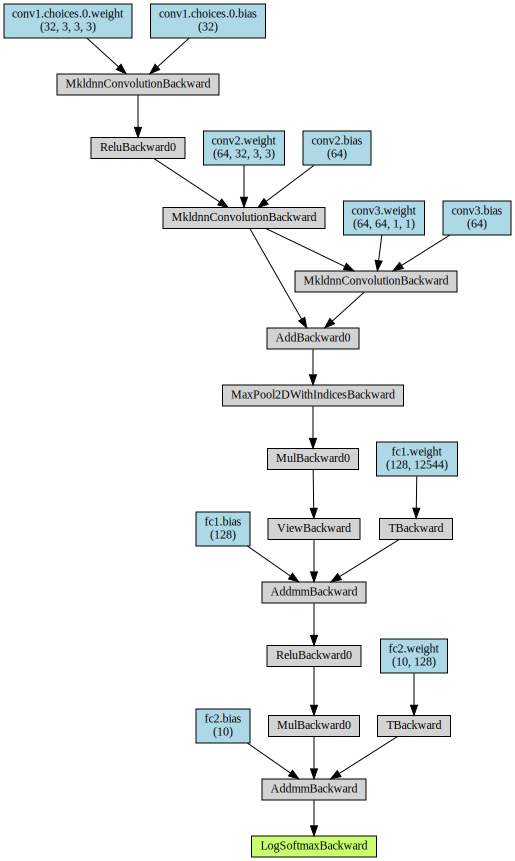

In [4]:
x = torch.Tensor(dataset_train.data[0].reshape((1, 3, 32, 32)))
y = model(x)
dot = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
dot

Fontions stored in the `graph.py` module of the project can be used to parse the graph from the pytorch object. There is an example in the following cells.

In [6]:
modules = list(model.named_modules())[1:]
search_space = graph.parse_modules(modules)
graphs = graph.get_search_space(deepcopy(search_space))
graphs

[{0: ('conv1.choices', 'Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))'),
  1: ('conv2', 'Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))'),
  2: ('conv3', 'Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))'),
  'skipcon': 'skipcon (conv2->conv3)',
  3: ('dropout1', 'Dropout2d(p=0.25, inplace=False)'),
  4: ('dropout2', 'Dropout2d(p=0.5, inplace=False)'),
  5: ('max_pool',
   'MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)'),
  6: ('fc1', 'Linear(in_features=12544, out_features=128, bias=True)'),
  7: ('fc2', 'Linear(in_features=128, out_features=10, bias=True)')},
 {0: ('conv1.choices', 'Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))'),
  1: ('conv2', 'Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))'),
  2: ('conv3', 'Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))'),
  'skipcon': 'skipcon (conv2->conv3)',
  3: ('dropout1', 'Dropout2d(p=0.25, inplace=False)'),
  4: ('dropout2', 'Dropout2d(p=0.5, inplace=False)'),
  5: ('max_pool',
   'MaxPool2d(ke

In [7]:
search_space

{0: [('conv1.choices', 'Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))'),
  ('conv1.choices', 'Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))')],
 1: ('conv2', 'Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))'),
 2: ('conv3', 'Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))'),
 'skipcon': 'skipcon (conv2->conv3)',
 3: ('dropout1', 'Dropout2d(p=0.25, inplace=False)'),
 4: ('dropout2', 'Dropout2d(p=0.5, inplace=False)'),
 5: ('max_pool',
  'MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)'),
 6: ('fc1', 'Linear(in_features=12544, out_features=128, bias=True)'),
 7: ('fc2', 'Linear(in_features=128, out_features=10, bias=True)')}

In [14]:
nodes, edges, adjacency = graph.get_graph_attribut(graphs[0])

In [15]:
edges

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (1, 3)]

In [16]:
nodes

[(0, 'Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))'),
 (1, 'Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))'),
 (2, 'Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))'),
 (3, 'Dropout2d(p=0.25, inplace=False)'),
 (4, 'Dropout2d(p=0.5, inplace=False)'),
 (5,
  'MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)'),
 (6, 'Linear(in_features=12544, out_features=128, bias=True)'),
 (7, 'Linear(in_features=128, out_features=10, bias=True)')]

In [17]:
adjacency

array([[0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])